In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [2]:
def partition(arr, start, end):
    # select last element as a pivot (from the book)
    pivot_index = end
    pivot_value = arr[end]
    
    left = start
    right = end - 1
    
    while True:
        while left < end and arr[left] < pivot_value:
            left += 1
        
        while right > start and arr[right] > pivot_value:
            right -= 1
        
        if left >= right:
            arr[left], arr[pivot_index] = arr[pivot_index], arr[left]
            return left
        else:
            arr[left], arr[right] = arr[right], arr[left]
        
        left += 1
        right -= 1
    
    raise Exception("unreachable")

def quicksort_implementation(arr, start, end):
    if end - start < 1:
        return
    
    pivot_index = partition(arr, start, end)
    quicksort_implementation(arr, pivot_index + 1, end)
    quicksort_implementation(arr, start, pivot_index - 1)

def quicksort(arr):
    quicksort_implementation(arr, 0, len(arr) - 1)
    
    return arr

In [3]:
# trivial sorts
print(quicksort([]))
print(quicksort([123]))

# ordered
print(quicksort([1, 2, 3]))
# reverse ordered
print(quicksort([3, 2, 1]))

# other permutations
print(quicksort([1, 3, 2]))
print(quicksort([2, 1, 3]))
print(quicksort([2, 3, 1]))
print(quicksort([3, 1, 2]))

[]
[123]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]


In [37]:
df = pd.DataFrame(columns=("array_size", "time"));

# be careful with size, because time complexity is quadratic
sizes = np.arange(1, 1000)
number_of_trials = 10

for array_size in sizes:
    arr = np.arange(array_size)
    rng = np.random.default_rng()
    rng.shuffle(arr)
    
    for i in range(number_of_trials):
        start = timer()
        sorted_arr = quicksort(arr)
        end = timer()
        delta = end - start
        
        new_row = {
            "array_size": array_size,
            "time": delta
        }
        
        df.loc[len(df)] = new_row

df

,array_size,time
0,1,0.000007
1,1,0.000005
2,1,0.000027
3,1,0.000004
4,1,0.000003
...,...,...
9985,999,0.120024
9986,999,0.126678
9987,999,0.110062
9988,999,0.116352


<AxesSubplot:xlabel='array_size', ylabel='time'>

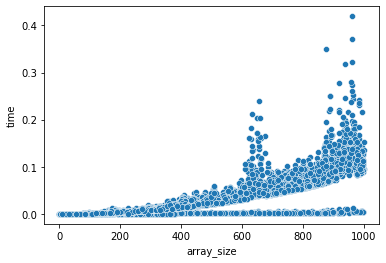

In [38]:
df_sample = df.sample(5000)
sns.scatterplot(data=df_sample, x="array_size", y="time")

<AxesSubplot:xlabel='array_size', ylabel='time'>

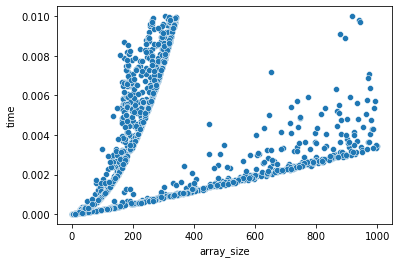

In [39]:
sns.scatterplot(data=df_sample[df_sample['time'] < 0.01], x="array_size", y="time")

Linear best case

In [40]:
df_mean_times = df.groupby('array_size', as_index=False).agg(mean_time=pd.NamedAgg(column="time", aggfunc="mean"))
df_mean_times

,array_size,mean_time
0,1,0.000006
1,2,0.000010
2,3,0.000008
3,4,0.000010
4,5,0.000012
...,...,...
994,995,0.095457
995,996,0.107058
996,997,0.099783
997,998,0.097367


<AxesSubplot:xlabel='array_size', ylabel='mean_time'>

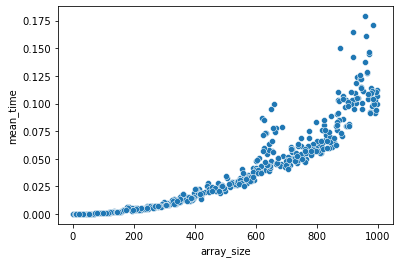

In [41]:
sns.scatterplot(data=df_mean_times.sample(500), x="array_size", y="mean_time")

Should be O(Nlog(N)) average case

Now i will try to estimate mean time with linear regression.

First i try to fit quadratic curve

In [42]:
df_regression = pd.DataFrame({
    'array_size': df_mean_times['array_size'],
    'array_size^2': df_mean_times['array_size']**2,
    'mean_time': df_mean_times['mean_time']
})
df_regression

,array_size,array_size^2,mean_time
0,1,1,0.000006
1,2,4,0.000010
2,3,9,0.000008
3,4,16,0.000010
4,5,25,0.000012
...,...,...,...
994,995,990025,0.095457
995,996,992016,0.107058
996,997,994009,0.099783
997,998,996004,0.097367


In [43]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = df_regression[['array_size', 'array_size^2']]
y = df_regression['mean_time']

model.fit(X, y)

LinearRegression()

In [44]:
model.coef_

array([-2.08681276e-05,  1.35919416e-07])

In [47]:
regression_array_size = np.arange(1, 1000)
df_regression_predicted = pd.DataFrame({
    'array_size': regression_array_size,
    'array_size^2': regression_array_size**2
})

df_regression_predicted['mean_time'] = model.predict(df_regression_predicted)

<AxesSubplot:xlabel='array_size', ylabel='mean_time'>

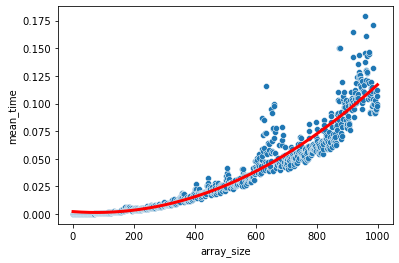

In [48]:
fig, ax = plt.subplots()

sns.scatterplot(ax=ax, data=df_mean_times, x="array_size", y="mean_time")
sns.lineplot(ax=ax, data=df_regression_predicted, x="array_size", y="mean_time", color="red", linewidth = 3)

And Nlog(N) curve

In [49]:
df_regression = pd.DataFrame({
    'array_size': df_mean_times['array_size'],
    'array_size * log2(array_size)': np.log2(df_mean_times['array_size']) * df_mean_times['array_size'],
    'mean_time': df_mean_times['mean_time']
})
df_regression

,array_size,array_size * log2(array_size),mean_time
0,1,0.000000,0.000006
1,2,2.000000,0.000010
2,3,4.754888,0.000008
3,4,8.000000,0.000010
4,5,11.609640,0.000012
...,...,...,...
994,995,9908.759952,0.095457
995,996,9920.161924,0.107058
996,997,9931.565345,0.099783
997,998,9942.970213,0.097367


In [50]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = df_regression[['array_size', 'array_size * log2(array_size)']]
y = df_regression['mean_time']

model.fit(X, y)

LinearRegression()

In [51]:
model.coef_

array([-5.86489290e-04,  6.87316509e-05])

In [54]:
regression_array_size = np.arange(1, 1000)
df_regression_predicted = pd.DataFrame({
    'array_size': regression_array_size,
    'array_size * log2(array_size)': regression_array_size * np.log2(regression_array_size)
})

df_regression_predicted['mean_time'] = model.predict(df_regression_predicted)

<AxesSubplot:xlabel='array_size', ylabel='mean_time'>

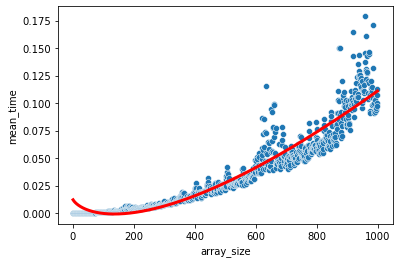

In [55]:
fig, ax = plt.subplots()

sns.scatterplot(ax=ax, data=df_mean_times, x="array_size", y="mean_time")
sns.lineplot(ax=ax, data=df_regression_predicted, x="array_size", y="mean_time", color="red", linewidth = 3)

Doesn't look like it fits better, maybe this is because pivot picking in partition function is pretty stupid. Or my m